In [50]:
import os
import random
import pandas as pd
import string
import math
import matplotlib.pyplot as plt
import xxhash
from implementations.hyperloglog import HyperLogLog
from implementations.recordinality import Recordinality
from implementations.zipfian_data_generator import ZipfianDataGenerator

In [2]:
random.seed(0xCAFFE) # for the sake of reproducibility

In [3]:
def rand_str(len: int):
    return ''.join(random.choices(string.ascii_lowercase, k=len))

In [4]:
rand_str(5)

'eyrqq'

In [5]:
def xxhash64(s: str):
    return xxhash.xxh64(s).intdigest()

In [6]:
def find_txt_files(directory):
    for entry in os.listdir(directory):
        if entry.endswith('.txt'):
            yield os.path.join(directory, entry)

In [7]:
def stream_from_file(filename: str):
    stream = []
    with open(filename, 'r') as file:
        for line in file:
            word = line.strip()
            stream.append(word)
    return stream

In [8]:
def stream_cardinality_estimation(stream: list[str], cardinality_estimator):
    ground_truth_count = len(set(stream))
    for word in stream:
        cardinality_estimator.add(word)
    estimation = cardinality_estimator.count()
    relative_error = abs(ground_truth_count - estimation) / ground_truth_count
    return ground_truth_count, estimation, relative_error


In [9]:
HLL = HyperLogLog(salt=rand_str(20), hash_f=xxhash64, hash_size=64, m=2**8)
HLL.count()

367.7555677437675

In [10]:
max(HLL.hash_leading_zeros(HLL.hash_f(str(4534543345+i)) & HLL.mask) for i in range(2**16))

15

In [11]:
HLL.hash_leading_zeros(2**2-1)

54

In [12]:
HLL.mask_len

56

In [13]:
ZDG = ZipfianDataGenerator(1, 10)
ZDG.random_stream(10)

['npsmpj',
 'gdauzd',
 'xwqbsf',
 'gdauzd',
 'gdauzd',
 'npsmpj',
 'lqewdz',
 'lqewdz',
 'lqewdz',
 'dwkury']

In [14]:
%%time
HLL = HyperLogLog(salt=rand_str(20), hash_f=xxhash64, hash_size=64, m=2**8)
stream = stream_from_file("datasets/quijote.txt")
stream_cardinality_estimation(stream, HLL)

CPU times: user 200 ms, sys: 7.49 ms, total: 208 ms
Wall time: 309 ms


(23034, 25206.37070317278, 0.09431148316283663)

In [15]:
N = 10**4
stream = ZipfianDataGenerator(alpha=1, n=N).random_stream(4*N)
HLL = HyperLogLog(salt=rand_str(20), hash_f=xxhash64, hash_size=64, m=2**8)
stream_cardinality_estimation(stream, HLL)

(6147, 6006.396458065446, 0.022873522357988355)

In [16]:
%%time
R = Recordinality(salt=rand_str(20), hash_f=xxhash64, k=2**8)
stream = stream_from_file("datasets/quijote.txt")
stream_cardinality_estimation(stream, R)

CPU times: user 165 ms, sys: 0 ns, total: 165 ms
Wall time: 166 ms


(23034, 22931.487303393824, 0.004450494773212476)

In [17]:
N = 10**4
stream = ZipfianDataGenerator(alpha=1, n=N).random_stream(4*N)
R = Recordinality(salt=rand_str(20), hash_f=xxhash64, k=2**8)
stream_cardinality_estimation(stream, R)

(6134, 6793.943652438786, 0.10758781422216916)

In [18]:
def evaluate_cardinality_estimation_method(n_rounds: int, stream: list[str], k: int, method: str):
    avg_count = 0
    avg_err = 0
    ground_truth = None
    for _ in range(n_rounds):
        if method == "HyperLogLog":
            cardest = HyperLogLog(salt=rand_str(20), hash_f=xxhash64, hash_size=64, m=k)
        elif method == "Recordinality":
            cardest = Recordinality(salt=rand_str(20), hash_f=xxhash64, k=k)
        else:
            assert False, "unknown method"
        ground_truth, count, err = stream_cardinality_estimation(stream, cardest)
        avg_count += count
        avg_err += err
    avg_count /= n_rounds
    avg_err /= n_rounds
    return ground_truth, avg_count, avg_err


In [19]:
evaluate_cardinality_estimation_method(10, stream, k=2**8, method="HyperLogLog")

(6134, 6289.697072148901, 0.05686661460812956)

In [30]:
n_rounds = 50
for filename in find_txt_files("datasets/"):
    stream = stream_from_file(filename)
    rows = []
    for k in [2**4, 2**5, 2**6, 2**7, 2**8]:
        print(k, len(stream))
        ground_truth, avg_HLL_count, avg_HLL_err = evaluate_cardinality_estimation_method(n_rounds, stream, k=k, method="HyperLogLog")
        ground_truth, avg_R_count, avg_R_err = evaluate_cardinality_estimation_method(n_rounds, stream, k=k, method="Recordinality")
        rows.append([k, ground_truth, round(avg_HLL_count, 2), round(avg_HLL_err, 2), round(avg_R_count, 2), round(avg_R_err, 2)])
    df = pd.DataFrame(rows, columns=['k', 'ground truth', 'avg HyperLogLog count', 'avg HyperLogLog error', 'avg Recordinality count', 'avg Recordinality error'])
    display(filename)
    display(df)
    print()
    print(' \\\\\n'.join(' & '.join(str(val) for val in row) for row in rows), '\\\\')
    print()


16 91813
32 91813
64 91813
128 91813
256 91813


'datasets/crusoe.txt'

,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,6245,6553.64,0.21,6534.87,0.43
1,32,6245,6417.58,0.13,6118.74,0.28
2,64,6245,6130.38,0.10,6465.84,0.21
3,128,6245,6371.87,0.08,6178.47,0.11
4,256,6245,6307.06,0.06,6252.52,0.07



16 & 6245 & 6553.64 & 0.21 & 6534.87 & 0.43 \\
32 & 6245 & 6417.58 & 0.13 & 6118.74 & 0.28 \\
64 & 6245 & 6130.38 & 0.1 & 6465.84 & 0.21 \\
128 & 6245 & 6371.87 & 0.08 & 6178.47 & 0.11 \\
256 & 6245 & 6307.06 & 0.06 & 6252.52 & 0.07 \\

16 124249
32 124249
64 124249
128 124249
256 124249


'datasets/dracula.txt'

,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,9425,9188.99,0.23,9240.10,0.41
1,32,9425,9628.33,0.12,9219.01,0.28
2,64,9425,9294.73,0.11,9160.89,0.18
3,128,9425,9363.30,0.06,9247.58,0.13
4,256,9425,9476.03,0.05,9235.84,0.09



16 & 9425 & 9188.99 & 0.23 & 9240.1 & 0.41 \\
32 & 9425 & 9628.33 & 0.12 & 9219.01 & 0.28 \\
64 & 9425 & 9294.73 & 0.11 & 9160.89 & 0.18 \\
128 & 9425 & 9363.3 & 0.06 & 9247.58 & 0.13 \\
256 & 9425 & 9476.03 & 0.05 & 9235.84 & 0.09 \\

16 264853
32 264853
64 264853
128 264853
256 264853


'datasets/quijote.txt'

,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,23034,23119.15,0.23,23445.19,0.43
1,32,23034,23675.95,0.13,19989.43,0.26
2,64,23034,23522.51,0.09,22975.30,0.25
3,128,23034,22560.43,0.08,22998.90,0.14
4,256,23034,22935.24,0.06,22870.97,0.10



16 & 23034 & 23119.15 & 0.23 & 23445.19 & 0.43 \\
32 & 23034 & 23675.95 & 0.13 & 19989.43 & 0.26 \\
64 & 23034 & 23522.51 & 0.09 & 22975.3 & 0.25 \\
128 & 23034 & 22560.43 & 0.08 & 22998.9 & 0.14 \\
256 & 23034 & 22935.24 & 0.06 & 22870.97 & 0.1 \\

16 47064
32 47064
64 47064
128 47064
256 47064


'datasets/valley-fear.txt'

,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,5830,5851.26,0.18,6025.14,0.37
1,32,5830,5793.01,0.14,5681.75,0.27
2,64,5830,5674.04,0.09,5977.93,0.20
3,128,5830,5888.80,0.06,6016.31,0.13
4,256,5830,5865.57,0.05,5754.55,0.07



16 & 5830 & 5851.26 & 0.18 & 6025.14 & 0.37 \\
32 & 5830 & 5793.01 & 0.14 & 5681.75 & 0.27 \\
64 & 5830 & 5674.04 & 0.09 & 5977.93 & 0.2 \\
128 & 5830 & 5888.8 & 0.06 & 6016.31 & 0.13 \\
256 & 5830 & 5865.57 & 0.05 & 5754.55 & 0.07 \\

16 458701
32 458701
64 458701
128 458701
256 458701


'datasets/war-peace.txt'

,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,17476,15769.85,0.20,16194.26,0.45
1,32,17476,16600.09,0.18,18526.45,0.34
2,64,17476,17332.37,0.11,17678.39,0.19
3,128,17476,17915.99,0.07,17751.07,0.13
4,256,17476,17322.84,0.05,17117.08,0.10



16 & 17476 & 15769.85 & 0.2 & 16194.26 & 0.45 \\
32 & 17476 & 16600.09 & 0.18 & 18526.45 & 0.34 \\
64 & 17476 & 17332.37 & 0.11 & 17678.39 & 0.19 \\
128 & 17476 & 17915.99 & 0.07 & 17751.07 & 0.13 \\
256 & 17476 & 17322.84 & 0.05 & 17117.08 & 0.1 \\

16 124944
32 124944
64 124944
128 124944
256 124944


'datasets/iliad.txt'

,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,8925,8643.12,0.18,8087.57,0.41
1,32,8925,9322.38,0.15,8274.16,0.30
2,64,8925,8898.57,0.11,8877.06,0.20
3,128,8925,8992.66,0.07,8962.32,0.13
4,256,8925,9049.55,0.05,8734.50,0.07



16 & 8925 & 8643.12 & 0.18 & 8087.57 & 0.41 \\
32 & 8925 & 9322.38 & 0.15 & 8274.16 & 0.3 \\
64 & 8925 & 8898.57 & 0.11 & 8877.06 & 0.2 \\
128 & 8925 & 8992.66 & 0.07 & 8962.32 & 0.13 \\
256 & 8925 & 9049.55 & 0.05 & 8734.5 & 0.07 \\

16 13609
32 13609
64 13609
128 13609
256 13609


'datasets/midsummer-nights-dream.txt'

,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,3136,3145.89,0.21,3137.59,0.36
1,32,3136,3153.62,0.14,3035.24,0.21
2,64,3136,3084.72,0.10,3167.45,0.16
3,128,3136,3119.67,0.07,3029.43,0.09
4,256,3136,3189.20,0.06,3098.82,0.07



16 & 3136 & 3145.89 & 0.21 & 3137.59 & 0.36 \\
32 & 3136 & 3153.62 & 0.14 & 3035.24 & 0.21 \\
64 & 3136 & 3084.72 & 0.1 & 3167.45 & 0.16 \\
128 & 3136 & 3119.67 & 0.07 & 3029.43 & 0.09 \\
256 & 3136 & 3189.2 & 0.06 & 3098.82 & 0.07 \\

16 18474
32 18474
64 18474
128 18474
256 18474


'datasets/mare-balena.txt'

,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,5670,5467.95,0.18,5455.86,0.40
1,32,5670,5527.14,0.13,5424.41,0.25
2,64,5670,5458.40,0.11,5707.85,0.20
3,128,5670,5644.65,0.07,5883.56,0.13
4,256,5670,5658.77,0.05,5756.44,0.08



16 & 5670 & 5467.95 & 0.18 & 5455.86 & 0.4 \\
32 & 5670 & 5527.14 & 0.13 & 5424.41 & 0.25 \\
64 & 5670 & 5458.4 & 0.11 & 5707.85 & 0.2 \\
128 & 5670 & 5644.65 & 0.07 & 5883.56 & 0.13 \\
256 & 5670 & 5658.77 & 0.05 & 5756.44 & 0.08 \\



In [62]:
n_rounds = 50
N = 10**4
for alpha in [1, 0.5, 2]:
    for n in [N//100, N//10, N, N*10]:
        stream = ZipfianDataGenerator(alpha=alpha, n=N).random_stream(n)
        rows = []
        for k in [2**4, 2**5, 2**6, 2**7, 2**8]:
            print(k, len(stream))
            ground_truth, avg_HLL_count, avg_HLL_err = evaluate_cardinality_estimation_method(n_rounds, stream, k=k, method="HyperLogLog")
            ground_truth, avg_R_count, avg_R_err = evaluate_cardinality_estimation_method(n_rounds, stream, k=k, method="Recordinality")
            rows.append([k, ground_truth, round(avg_HLL_count, 2), round(avg_HLL_err, 2), round(avg_R_count, 2), round(avg_R_err, 2)])
        df = pd.DataFrame(rows, columns=['k', 'ground truth', 'avg HyperLogLog count', 'avg HyperLogLog error', 'avg Recordinality count', 'avg Recordinality error'])
        print(f'Zipfian data, alpha={alpha}, N={8000}, n={n}')
        display(df)
        print()
        print(' \\\\\n'.join(' & '.join(str(val) for val in row) for row in rows), '\\\\')
        print()

16 100
32 100
64 100
128 100
256 100
Zipfian data, alpha=1, N=8000, n=100


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,75,76.03,0.18,73.47,0.16
1,32,75,88.81,0.18,76.32,0.07
2,64,75,131.01,0.75,74.96,0.01
3,128,75,221.67,1.96,75.00,0.00
4,256,75,405.11,4.40,75.00,0.00



16 & 75 & 76.03 & 0.18 & 73.47 & 0.16 \\
32 & 75 & 88.81 & 0.18 & 76.32 & 0.07 \\
64 & 75 & 131.01 & 0.75 & 74.96 & 0.01 \\
128 & 75 & 221.67 & 1.96 & 75.0 & 0.0 \\
256 & 75 & 405.11 & 4.4 & 75.0 & 0.0 \\

16 1000
32 1000
64 1000
128 1000
256 1000
Zipfian data, alpha=1, N=8000, n=1000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,556,544.87,0.19,605.91,0.32
1,32,556,545.35,0.13,551.97,0.18
2,64,556,550.31,0.09,549.91,0.11
3,128,556,583.12,0.07,557.58,0.06
4,256,556,705.88,0.27,552.77,0.03



16 & 556 & 544.87 & 0.19 & 605.91 & 0.32 \\
32 & 556 & 545.35 & 0.13 & 551.97 & 0.18 \\
64 & 556 & 550.31 & 0.09 & 549.91 & 0.11 \\
128 & 556 & 583.12 & 0.07 & 557.58 & 0.06 \\
256 & 556 & 705.88 & 0.27 & 552.77 & 0.03 \\

16 10000
32 10000
64 10000
128 10000
256 10000
Zipfian data, alpha=1, N=8000, n=10000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,2859,2815.73,0.17,2650.07,0.34
1,32,2859,2808.94,0.16,2831.96,0.26
2,64,2859,2768.93,0.11,2895.35,0.17
3,128,2859,2823.15,0.06,2782.35,0.09
4,256,2859,2884.01,0.05,2830.01,0.05



16 & 2859 & 2815.73 & 0.17 & 2650.07 & 0.34 \\
32 & 2859 & 2808.94 & 0.16 & 2831.96 & 0.26 \\
64 & 2859 & 2768.93 & 0.11 & 2895.35 & 0.17 \\
128 & 2859 & 2823.15 & 0.06 & 2782.35 & 0.09 \\
256 & 2859 & 2884.01 & 0.05 & 2830.01 & 0.05 \\

16 100000
32 100000
64 100000
128 100000
256 100000
Zipfian data, alpha=1, N=8000, n=100000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,8590,8716.61,0.19,8505.49,0.39
1,32,8590,8558.85,0.12,8569.93,0.30
2,64,8590,8600.91,0.09,9148.81,0.24
3,128,8590,8613.77,0.08,8806.57,0.14
4,256,8590,8753.73,0.05,8616.17,0.07



16 & 8590 & 8716.61 & 0.19 & 8505.49 & 0.39 \\
32 & 8590 & 8558.85 & 0.12 & 8569.93 & 0.3 \\
64 & 8590 & 8600.91 & 0.09 & 9148.81 & 0.24 \\
128 & 8590 & 8613.77 & 0.08 & 8806.57 & 0.14 \\
256 & 8590 & 8753.73 & 0.05 & 8616.17 & 0.07 \\

16 100
32 100
64 100
128 100
256 100
Zipfian data, alpha=0.5, N=8000, n=100


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,100,95.92,0.18,94.19,0.23
1,32,100,108.10,0.12,96.88,0.09
2,64,100,149.03,0.49,99.59,0.03
3,128,100,237.38,1.37,100.00,0.00
4,256,100,418.04,3.18,100.00,0.00



16 & 100 & 95.92 & 0.18 & 94.19 & 0.23 \\
32 & 100 & 108.1 & 0.12 & 96.88 & 0.09 \\
64 & 100 & 149.03 & 0.49 & 99.59 & 0.03 \\
128 & 100 & 237.38 & 1.37 & 100.0 & 0.0 \\
256 & 100 & 418.04 & 3.18 & 100.0 & 0.0 \\

16 1000
32 1000
64 1000
128 1000
256 1000
Zipfian data, alpha=0.5, N=8000, n=1000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,903,830.66,0.17,901.32,0.26
1,32,903,919.56,0.12,858.20,0.21
2,64,903,882.83,0.13,888.31,0.14
3,128,903,918.05,0.07,898.69,0.07
4,256,903,958.24,0.07,904.58,0.03



16 & 903 & 830.66 & 0.17 & 901.32 & 0.26 \\
32 & 903 & 919.56 & 0.12 & 858.2 & 0.21 \\
64 & 903 & 882.83 & 0.13 & 888.31 & 0.14 \\
128 & 903 & 918.05 & 0.07 & 898.69 & 0.07 \\
256 & 903 & 958.24 & 0.07 & 904.58 & 0.03 \\

16 10000
32 10000
64 10000
128 10000
256 10000
Zipfian data, alpha=0.5, N=8000, n=10000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,5610,5447.22,0.17,5548.73,0.41
1,32,5610,5724.76,0.13,5510.69,0.28
2,64,5610,5526.96,0.11,5872.09,0.18
3,128,5610,5588.62,0.07,5544.38,0.11
4,256,5610,5595.76,0.05,5529.68,0.07



16 & 5610 & 5447.22 & 0.17 & 5548.73 & 0.41 \\
32 & 5610 & 5724.76 & 0.13 & 5510.69 & 0.28 \\
64 & 5610 & 5526.96 & 0.11 & 5872.09 & 0.18 \\
128 & 5610 & 5588.62 & 0.07 & 5544.38 & 0.11 \\
256 & 5610 & 5595.76 & 0.05 & 5529.68 & 0.07 \\

16 100000
32 100000
64 100000
128 100000
256 100000
Zipfian data, alpha=0.5, N=8000, n=100000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,9985,9216.91,0.22,10750.99,0.50
1,32,9985,9748.64,0.14,9851.84,0.33
2,64,9985,10083.96,0.10,10015.29,0.20
3,128,9985,10065.60,0.08,9864.17,0.11
4,256,9985,9948.41,0.05,10083.77,0.07



16 & 9985 & 9216.91 & 0.22 & 10750.99 & 0.5 \\
32 & 9985 & 9748.64 & 0.14 & 9851.84 & 0.33 \\
64 & 9985 & 10083.96 & 0.1 & 10015.29 & 0.2 \\
128 & 9985 & 10065.6 & 0.08 & 9864.17 & 0.11 \\
256 & 9985 & 9948.41 & 0.05 & 10083.77 & 0.07 \\

16 100
32 100
64 100
128 100
256 100
Zipfian data, alpha=2, N=8000, n=100


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,10,26.57,1.66,10.0,0.0
1,32,10,49.31,3.93,10.0,0.0
2,64,10,95.49,8.55,10.0,0.0
3,128,10,188.34,17.83,10.0,0.0
4,256,10,373.11,36.31,10.0,0.0



16 & 10 & 26.57 & 1.66 & 10.0 & 0.0 \\
32 & 10 & 49.31 & 3.93 & 10.0 & 0.0 \\
64 & 10 & 95.49 & 8.55 & 10.0 & 0.0 \\
128 & 10 & 188.34 & 17.83 & 10.0 & 0.0 \\
256 & 10 & 373.11 & 36.31 & 10.0 & 0.0 \\

16 1000
32 1000
64 1000
128 1000
256 1000
Zipfian data, alpha=2, N=8000, n=1000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,37,44.85,0.23,36.43,0.11
1,32,37,64.61,0.75,36.91,0.02
2,64,37,109.02,1.95,37.00,0.00
3,128,37,201.72,4.45,37.00,0.00
4,256,37,387.06,9.46,37.00,0.00



16 & 37 & 44.85 & 0.23 & 36.43 & 0.11 \\
32 & 37 & 64.61 & 0.75 & 36.91 & 0.02 \\
64 & 37 & 109.02 & 1.95 & 37.0 & 0.0 \\
128 & 37 & 201.72 & 4.45 & 37.0 & 0.0 \\
256 & 37 & 387.06 & 9.46 & 37.0 & 0.0 \\

16 10000
32 10000
64 10000
128 10000
256 10000
Zipfian data, alpha=2, N=8000, n=10000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,129,136.30,0.20,127.45,0.18
1,32,129,133.43,0.13,130.68,0.10
2,64,129,167.12,0.30,127.57,0.05
3,128,129,254.28,0.97,128.99,0.00
4,256,129,433.10,2.36,129.00,0.00



16 & 129 & 136.3 & 0.2 & 127.45 & 0.18 \\
32 & 129 & 133.43 & 0.13 & 130.68 & 0.1 \\
64 & 129 & 167.12 & 0.3 & 127.57 & 0.05 \\
128 & 129 & 254.28 & 0.97 & 128.99 & 0.0 \\
256 & 129 & 433.1 & 2.36 & 129.0 & 0.0 \\

16 100000
32 100000
64 100000
128 100000
256 100000
Zipfian data, alpha=2, N=8000, n=100000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,441,402.07,0.22,452.41,0.31
1,32,441,443.68,0.15,457.74,0.19
2,64,441,445.52,0.09,440.09,0.12
3,128,441,475.45,0.09,439.31,0.06
4,256,441,625.09,0.42,439.13,0.02



16 & 441 & 402.07 & 0.22 & 452.41 & 0.31 \\
32 & 441 & 443.68 & 0.15 & 457.74 & 0.19 \\
64 & 441 & 445.52 & 0.09 & 440.09 & 0.12 \\
128 & 441 & 475.45 & 0.09 & 439.31 & 0.06 \\
256 & 441 & 625.09 & 0.42 & 439.13 & 0.02 \\



In [69]:
N = 10**5
STREAM_SIZE = 10**8
BATCH_SIZE = 10**5
alpha = 1
rows = []
HLL_errors = []
R_errors = []
k_values = [2**4, 2**8, 2**10]
for k in k_values:
    generator = ZipfianDataGenerator(alpha=alpha, n=N)
    HLL = HyperLogLog(salt=rand_str(20), hash_f=xxhash64, hash_size=64, m=k)
    R = Recordinality(salt=rand_str(20), hash_f=xxhash64, k=k)
    S = set()
    for btch in range(STREAM_SIZE // BATCH_SIZE):
        if (btch % 100 == 0):
            print(btch/(STREAM_SIZE // BATCH_SIZE), k)
        stream = generator.random_stream(BATCH_SIZE)
        for word in stream:
            S.add(word)
            HLL.add(word)
            R.add(word)
    HLL_count = HLL.count()
    R_count = R.count()
    ground_truth = len(S)
    HLL_err = abs(HLL_count - ground_truth) / ground_truth
    R_err = abs(R_count - ground_truth) / ground_truth
    HLL_errors.append(HLL_err)
    R_errors.append(R_err)
    rows.append([k, ground_truth, round(HLL_count, 2), round(HLL_err, 2), round(R_count, 2), round(R_err, 2)])
            
df = pd.DataFrame(rows, columns=['k', 'ground truth', 'avg HyperLogLog count', 'avg HyperLogLog error', 'avg Recordinality count', 'avg Recordinality error'])
print(f'Zipfian data, alpha={alpha}, N={N}, n={STREAM_SIZE}')
display(df)
print()
print(' \\\\\n'.join(' & '.join(str(val) for val in row) for row in rows), '\\\\')
print()
 
        

0.0 16
0.1 16
0.2 16
0.3 16
0.4 16
0.5 16
0.6 16
0.7 16
0.8 16
0.9 16
0.0 256
0.1 256
0.2 256
0.3 256
0.4 256
0.5 256
0.6 256
0.7 256
0.8 256
0.9 256
0.0 1024
0.1 1024
0.2 1024
0.3 1024
0.4 1024
0.5 1024
0.6 1024
0.7 1024
0.8 1024
0.9 1024
Zipfian data, alpha=1, N=100000, n=100000000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,100000,94387.18,0.06,93143.72,0.07
1,256,100000,108939.80,0.09,111218.30,0.11
2,1024,100000,98402.56,0.02,105133.92,0.05



16 & 100000 & 94387.18 & 0.06 & 93143.72 & 0.07 \\
256 & 100000 & 108939.8 & 0.09 & 111218.3 & 0.11 \\
1024 & 100000 & 98402.56 & 0.02 & 105133.92 & 0.05 \\



In [73]:
N = 10**4
STREAM_SIZE = 10**6
BATCH_SIZE = 10**4
alpha = 1
rows = []
HLL_errors = []
R_errors = []
k_values = [2**4, 2**5, 2**6, 2**7, 2**8, 2**9]
for k in k_values:
    generator = ZipfianDataGenerator(alpha=alpha, n=N)
    HLL = HyperLogLog(salt=rand_str(20), hash_f=xxhash64, hash_size=64, m=k)
    R = Recordinality(salt=rand_str(20), hash_f=xxhash64, k=k)
    S = set()
    for btch in range(STREAM_SIZE // BATCH_SIZE):
        if (btch % 10 == 0):
            print(btch/(STREAM_SIZE // BATCH_SIZE), k)
        stream = generator.random_stream(BATCH_SIZE)
        for word in stream:
            S.add(word)
            HLL.add(word)
            R.add(word)
    HLL_count = HLL.count()
    R_count = R.count()
    ground_truth = len(S)
    HLL_err = abs(HLL_count - ground_truth) / ground_truth
    R_err = abs(R_count - ground_truth) / ground_truth
    HLL_errors.append(HLL_err)
    R_errors.append(R_err)
    rows.append([k, ground_truth, round(HLL_count, 2), round(HLL_err, 2), round(R_count, 2), round(R_err, 2)])
            
df = pd.DataFrame(rows, columns=['k', 'ground truth', 'avg HyperLogLog count', 'avg HyperLogLog error', 'avg Recordinality count', 'avg Recordinality error'])
print(f'Zipfian data, alpha={alpha}, N={N}, n={STREAM_SIZE}')
display(df)
print()
print(' \\\\\n'.join(' & '.join(str(val) for val in row) for row in rows), '\\\\')
print()
 
        

0.0 16
0.1 16
0.2 16
0.3 16
0.4 16
0.5 16
0.6 16
0.7 16
0.8 16
0.9 16
0.0 32
0.1 32
0.2 32
0.3 32
0.4 32
0.5 32
0.6 32
0.7 32
0.8 32
0.9 32
0.0 64
0.1 64
0.2 64
0.3 64
0.4 64
0.5 64
0.6 64
0.7 64
0.8 64
0.9 64
0.0 128
0.1 128
0.2 128
0.3 128
0.4 128
0.5 128
0.6 128
0.7 128
0.8 128
0.9 128
0.0 256
0.1 256
0.2 256
0.3 256
0.4 256
0.5 256
0.6 256
0.7 256
0.8 256
0.9 256
0.0 512
0.1 512
0.2 512
0.3 512
0.4 512
0.5 512
0.6 512
0.7 512
0.8 512
0.9 512
Zipfian data, alpha=1, N=10000, n=1000000


,k,ground truth,avg HyperLogLog count,avg HyperLogLog error,avg Recordinality count,avg Recordinality error
0,16,10000,12715.16,0.27,7755.61,0.22
1,32,10000,7093.55,0.29,4974.53,0.50
2,64,10000,10735.60,0.07,17524.26,0.75
3,128,10000,11551.19,0.16,9034.00,0.10
4,256,10000,10153.76,0.02,10473.33,0.05
5,512,10000,9881.18,0.01,10015.45,0.00



16 & 10000 & 12715.16 & 0.27 & 7755.61 & 0.22 \\
32 & 10000 & 7093.55 & 0.29 & 4974.53 & 0.5 \\
64 & 10000 & 10735.6 & 0.07 & 17524.26 & 0.75 \\
128 & 10000 & 11551.19 & 0.16 & 9034.0 & 0.1 \\
256 & 10000 & 10153.76 & 0.02 & 10473.33 & 0.05 \\
512 & 10000 & 9881.18 & 0.01 & 10015.45 & 0.0 \\



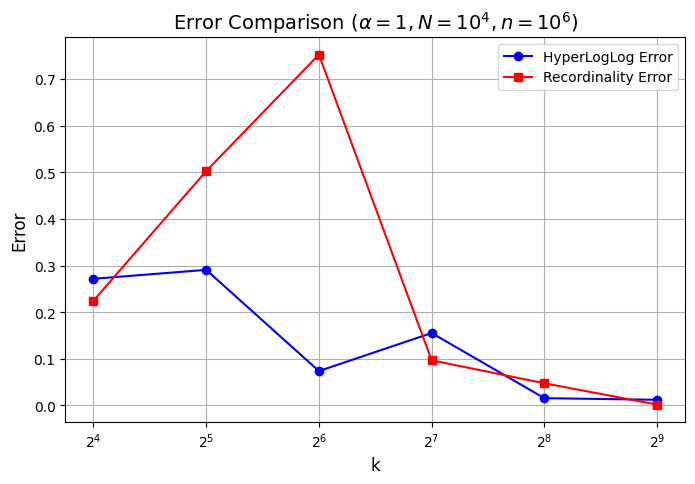

In [76]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, HLL_errors, marker='o', label='HyperLogLog Error', color='blue')
plt.plot(k_values, R_errors, marker='s', label='Recordinality Error', color='red')

# Adding labels and title
plt.xlabel('k', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Error Comparison $(\\alpha=1, N=10^4, n=10^6)$', fontsize=14)
plt.legend()
plt.grid(True)
plt.xscale('log', base=2)  # Base 2 logarithmic scale

# Show the plot
plt.savefig("img/comparison.png", dpi=300, bbox_inches='tight')
plt.show()
